# Profile analysis - One profile at a time

This notebooks takes output from ```ADV_data_01_process_vXX.ipynb``` and performs analysis on the profile data. In this version, users select an individual profile and can look at plots of the profile. In ```ADV_data_02_all_profiles-vXX.ipynb```, the same profile analysis is run to produce the summary output, but it is done on all profiles in the main database at once with no plots.

Needs:
- a file called ```summary_velocity_mean.csv``` which is the natural output of the above referenced notebook
- a file called ```summary_coniditions_locations.csv``` to provide spatial information for the 

User input:
- Data folder
- Run to analyze
- Profile $x$ location
- Water temperature

Version/Change log:
- V01: only works with profiles
- V02: works with the big master dataset. Some changes in the column names were made from V01 to work with the output form from master Google sheet

## Loads

In [1]:
# %pylab inline
import numpy as np
from numpy import log, sin, cos, exp, tan, pi
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%matplotlib inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

# uncomment the two lines below when exporting to a pdf
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png','pdf')

## Functions

In [2]:
#returns the clear-water density in kg/m^3 as a function of temperature [in deg C] and salinity [ppt]
def rho_cw(T,S): 
    rho_fresh=1000*(1-(T +288.9414)/(508929.2*(T+68.12963))*(T-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*T + 0.000076438*T**2 -0.00000082467*T**3 + 0.0000000053675*T**4
    Bcoef = -0.005724 + 0.00010227*T - 0.0000016546*T**2
    return rho_fresh + Acoef*S + Bcoef*S**(3/2) + 0.00048314*S**2 

# returns the clear water kinimatic viscosity in [m^2/s] as a function of temperature [in deg C].
def visc(T):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*T)

def swlogfit(z, ustar):
    Bs = 5.5
    return (ustar/kappa)*log(ustar*z/nu)+ustar*Bs

def rwlogfit(z, ks, ustar):
    Br = 8.5
    z0 = 0.25*ks
    # z0 = 0
    return (ustar/kappa)*log((z+z0)/ks)+ustar*Br

def rwlogfit2(z, z0, ks, ustar):
    Br = 8.5
    # z0 = 0.25*ks
    # z0 = 0
    return (ustar/kappa)*log((z+z0)/ks)+ustar*Br

## Find and load the data

In [3]:
""" --- User input ----------------------------- """

# datadir = 'ADV_test/' # path to the data
datadir = 'test_data/' # path to the data

"""  ------------------------------------------- """

veldatafile = 'summary_velocity_mean.csv'
conditionlocationfile = 'summary_coniditions_locations.csv'

fig_folder = 'Figures'
# Make the output folder
if os.path.isdir(fig_folder) != 1:
    os.mkdir(fig_folder)

data = pd.read_csv(datadir+veldatafile) # reads in the data
info = pd.read_csv(datadir+conditionlocationfile) # reads in the data

In [4]:
data

,Run,Point,uavg_m_s,vavg_m_s,wavg_m_s,uu_bar,uv_bar,uw_bar,vv_bar,vw_bar,ww_bar,snr1,snr2,snr3,snr4,cor1,cor2,cor3,cor4
0,Run1B,1,0.508021,-0.015163,-0.006950,0.013791,-0.002389,-0.003682,0.004937,0.001430,0.007298,18.651585,21.108743,15.822623,15.765246,80.323497,80.427322,79.989071,78.488525
1,Run1B,2,0.578202,-0.003716,-0.009438,0.014849,-0.000828,-0.004090,0.004062,0.000463,0.007116,18.663321,21.114686,15.837122,15.757269,81.775646,81.966790,80.592620,80.538007
2,Run1B,3,0.641050,-0.002523,-0.010512,0.012055,-0.001475,-0.003125,0.003970,0.000676,0.005598,18.662935,21.112507,15.837407,15.764306,82.431182,83.056539,81.330668,81.260994
3,Run1B,4,0.701200,0.003747,-0.020070,0.010088,-0.001173,-0.002476,0.003661,0.000246,0.005176,18.662267,21.110010,15.837684,15.762022,83.650147,84.317959,82.864573,82.218842
4,Run1B,5,0.779713,-0.000025,-0.027955,0.008809,-0.000826,-0.001892,0.002521,0.000229,0.003819,18.664558,21.115220,15.844421,15.761608,85.416845,85.902950,84.557931,84.734074
5,Run1B,6,0.853329,-0.007601,-0.046137,0.005580,-0.000504,-0.001427,0.001904,0.000352,0.012561,18.665824,21.114598,15.836475,14.979693,87.985441,88.165134,86.896169,77.106897
6,Run1B,7,0.620484,0.022383,0.056355,0.010572,-0.000154,-0.001848,0.003010,0.000225,0.004831,18.654204,21.103347,15.845020,15.752653,85.489796,85.936327,84.805714,84.132653
7,Run1B,8,0.810672,0.056857,0.124392,0.005420,-0.000353,0.000310,0.002744,0.000485,0.003146,18.646386,21.101635,15.836360,15.746256,84.309811,84.952668,84.165663,82.887263
8,Run1B,9,0.980984,0.012623,0.073426,0.004257,0.000907,0.001067,0.002353,-0.001701,0.155131,18.649180,21.091803,15.819672,13.557377,77.770492,77.459016,79.754098,29.737705
9,Run1B,10,-0.201621,-0.017909,0.056727,0.009250,0.001457,-0.001828,0.005978,-0.000400,0.011214,18.634361,21.089676,15.814638,15.735439,83.850539,83.243451,82.746533,81.138675


In [5]:
info

,File,Q_cms,S_p,T_cm,x_m,h_cm,z_cm,air,notes
0,Run1A_01.dat,0.099,0.50,7.8,5.12,12.5,1.7,0.0,NaN
1,Run1A_02.dat,0.099,0.50,7.8,5.12,12.5,2.7,0.0,NaN
2,Run1A_03.dat,0.099,0.50,7.8,5.12,12.5,3.7,0.0,NaN
3,Run1A_04.dat,0.099,0.50,7.8,5.12,12.5,5.7,0.0,NaN
4,Run1A_05.dat,0.099,0.50,7.8,5.12,12.5,7.7,0.0,NaN
...,...,...,...,...,...,...,...,...,...
123,Run3D_07.dat,0.139,0.75,8.0,4.00,11.4,4.5,0.0,NaN
124,Run3D_08.dat,0.139,0.75,8.0,3.85,8.9,3.1,0.0,NaN
125,Run3D_09.dat,0.139,0.75,8.0,3.70,7.8,2.1,1.0,NaN
126,Run3D_10.dat,0.139,0.75,8.0,3.50,8.0,2.5,1.0,NaN


In [6]:
info.insert(loc=1,column='Run',value=info.File.str[0:5])
info.insert(loc=2,column='Point',value=info.File.str[6:8].astype(int))
info.insert(loc=4,column='S',value=info.S_p/100)
info

,File,Run,Point,Q_cms,S,S_p,T_cm,x_m,h_cm,z_cm,air,notes
0,Run1A_01.dat,Run1A,1,0.099,0.0050,0.50,7.8,5.12,12.5,1.7,0.0,NaN
1,Run1A_02.dat,Run1A,2,0.099,0.0050,0.50,7.8,5.12,12.5,2.7,0.0,NaN
2,Run1A_03.dat,Run1A,3,0.099,0.0050,0.50,7.8,5.12,12.5,3.7,0.0,NaN
3,Run1A_04.dat,Run1A,4,0.099,0.0050,0.50,7.8,5.12,12.5,5.7,0.0,NaN
4,Run1A_05.dat,Run1A,5,0.099,0.0050,0.50,7.8,5.12,12.5,7.7,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
123,Run3D_07.dat,Run3D,7,0.139,0.0075,0.75,8.0,4.00,11.4,4.5,0.0,NaN
124,Run3D_08.dat,Run3D,8,0.139,0.0075,0.75,8.0,3.85,8.9,3.1,0.0,NaN
125,Run3D_09.dat,Run3D,9,0.139,0.0075,0.75,8.0,3.70,7.8,2.1,1.0,NaN
126,Run3D_10.dat,Run3D,10,0.139,0.0075,0.75,8.0,3.50,8.0,2.5,1.0,NaN


In [7]:
runs = info.Run.unique()
runs

array(['Run1A', 'Run1B', 'Run1C', 'Run1D', 'Run2A', 'Run2B', 'Run2C',
       'Run2D', 'Run3A', 'Run3B', 'Run3C', 'Run3D'], dtype=object)

In [8]:
# use to get the profile
# info['Point'].duplicated().any()
# info[info.duplicated(['x_m'], keep=False)]

## Define the run and profile to analyze

Uses the user input of the profile location and run to pull out data from the two ```.csv``` files and create a new ```profile``` dataframe to work with

In [12]:
""" --- User input ----------------------------- """

run = 'Run1B'
profilex = 5.12

T = 10 # water temperature in deg C

w = 1.2
B = 8.5
kappa = 0.41

"""  ------------------------------------------- """

pinfo = info[(info.Run == run)&(info.x_m == profilex)].copy() # pull out the profile for the run
pinfo = pinfo.sort_values(by=['Point']).reset_index(drop=True) # sort the data on the points in case something is out of order

first = pinfo.Point.min() # define which points are part of the profile - the first
last = pinfo.Point.max()  # define which points are part of the profile - the last
pdata = data[(data.Run == run)&(data.Point >= first)&(data.Point <= last)].copy() # pull out the profile for the run
pdata = pdata.sort_values(by=['Point']).reset_index(drop=True)   # sort the data on the points in case something is out of order

# drop data in the combine... drop run and point since they are duplicate; snr and cor dropped for visual check... might want them if looking at data quality
pinfo = pinfo.drop(columns=['Run','Point'])
pdata = pdata.drop(columns=['snr1','snr2','snr3','snr4','cor1','cor2','cor3','cor4'])

profile = pd.concat([pinfo,pdata], axis=1)
profile

,File,Q_cms,S,S_p,T_cm,x_m,h_cm,z_cm,air,notes,...,Point,uavg_m_s,vavg_m_s,wavg_m_s,uu_bar,uv_bar,uw_bar,vv_bar,vw_bar,ww_bar
0,Run1B_01.dat,0.113,0.005,0.5,7.8,5.12,12.8,1.7,0.0,h_wall 13.8,...,1,0.508021,-0.015163,-0.006950,0.013791,-0.002389,-0.003682,0.004937,0.001430,0.007298
1,Run1B_02.dat,0.113,0.005,0.5,7.8,5.12,12.8,2.7,0.0,h_wall 13.8,...,2,0.578202,-0.003716,-0.009438,0.014849,-0.000828,-0.004090,0.004062,0.000463,0.007116
2,Run1B_03.dat,0.113,0.005,0.5,7.8,5.12,12.8,3.7,0.0,h_wall 13.8,...,3,0.641050,-0.002523,-0.010512,0.012055,-0.001475,-0.003125,0.003970,0.000676,0.005598
3,Run1B_04.dat,0.113,0.005,0.5,7.8,5.12,12.8,5.7,0.0,h_wall 13.8,...,4,0.701200,0.003747,-0.020070,0.010088,-0.001173,-0.002476,0.003661,0.000246,0.005176
4,Run1B_05.dat,0.113,0.005,0.5,7.8,5.12,12.8,7.7,0.0,h_wall 13.8,...,5,0.779713,-0.000025,-0.027955,0.008809,-0.000826,-0.001892,0.002521,0.000229,0.003819
5,Run1B_06.dat,0.113,0.005,0.5,7.8,5.12,12.8,10.7,1.0,Top 2 receivers in air,...,6,0.853329,-0.007601,-0.046137,0.005580,-0.000504,-0.001427,0.001904,0.000352,0.012561


## Prelim calcs and profile plots

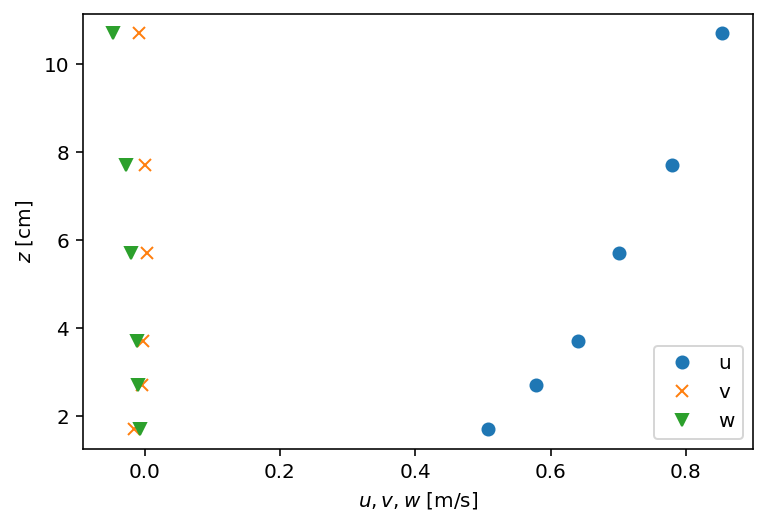

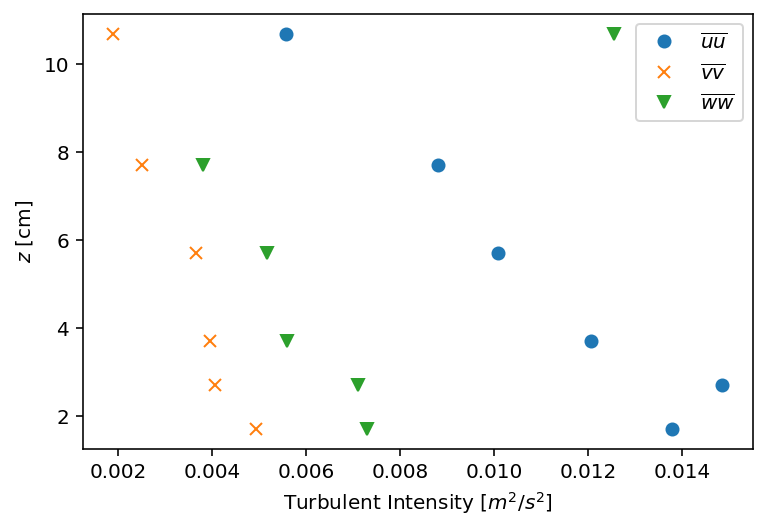

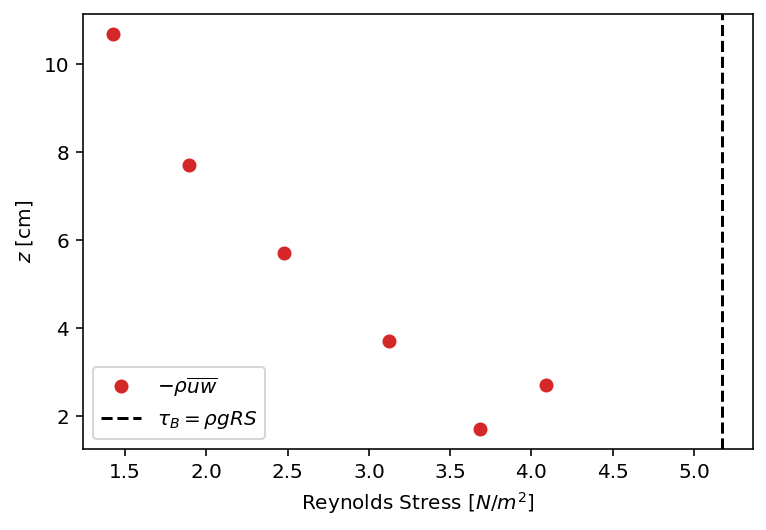

In [13]:
# resort the dataframe for better plotting and curve fitting

profile = profile.sort_values(by=['z_cm']).reset_index(drop=True) # sort the data on the points in case something is out of order

# prelim calcs

g = 9.81
nu = visc(T)
rho = rho_cw(T,0)
S = profile.S[0]
h = profile.h_cm[0]/100
R = h*w/(w+2*h)

taub_ds = rho*g*R*S # bed shear stress from depth slope product
ustar_ds = np.sqrt(taub_ds/rho)

# plot the profiles

fig, ax = plt.subplots()
ax.plot(profile.uavg_m_s,profile.z_cm, 'o', alpha=1, label='u')
ax.plot(profile.vavg_m_s,profile.z_cm,'x', alpha=1, label='v')
ax.plot(profile.wavg_m_s,profile.z_cm, 'v', alpha=1, label='w')
ax.set_xlabel('$u,v,w$ [m/s]')
ax.set_ylabel('$z$ [cm]')
# ax.set_ylim(-0.25,0.7)
# ax.text(0,-0.2, datapt[j]+' ($z/h =$'+str(np.around(zdata.z_h[j],decimals=2))+')', backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc='best', ncol=1)
plt.savefig(fig_folder+'/'+run+'_profile_avg.pdf',bbox_inches="tight", pad_inches=0.005)

fig, ax = plt.subplots()
ax.plot(profile.uu_bar,profile.z_cm, 'o', alpha=1, label=r'$\overline{uu}$')
ax.plot(profile.vv_bar,profile.z_cm,'x', alpha=1, label=r'$\overline{vv}$')
ax.plot(profile.ww_bar,profile.z_cm, 'v', alpha=1, label=r'$\overline{ww}$')
ax.set_xlabel('Turbulent Intensity $[m^2/s^2]$')
ax.set_ylabel('$z$ [cm]')
# ax.set_ylim(-0.25,0.7)
# ax.text(0,-0.2, datapt[j]+' ($z/h =$'+str(np.around(zdata.z_h[j],decimals=2))+')', backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc='best', ncol=1)
plt.savefig(fig_folder+'/'+run+'_TurbIntensity_avg.pdf',bbox_inches="tight", pad_inches=0.005)

fig, ax = plt.subplots()
ax.plot(-rho*profile.uw_bar,profile.z_cm, 'o', alpha=1,  color='C03', label=r'$-\rho\overline{uw}$')
ax.axvline(x=taub_ds, color='black',linestyle='--', label=r'$\tau_B = \rho g R S$')
ax.set_xlabel('Reynolds Stress $[N/m^2]$')
ax.set_ylabel('$z$ [cm]')
# ax.set_ylim(-0.25,0.7)
# ax.text(0,-0.2, datapt[j]+' ($z/h =$'+str(np.around(zdata.z_h[j],decimals=2))+')', backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc='best', ncol=1)
plt.savefig(fig_folder+'/'+run+'_ReynoldsStress_avg.pdf',bbox_inches="tight", pad_inches=0.005);

## Profile analysis

The depth average velocity, Uavg, is = 0.71 [m/s]
Discharge based on Uavg and flow area = 0.11 [cms]

u* [m/s] = 0.0763
taub [N/m^2] = 5.8179
ks [m] = 0.03835
ks+ = 2204.0
R^2 = 0.9904


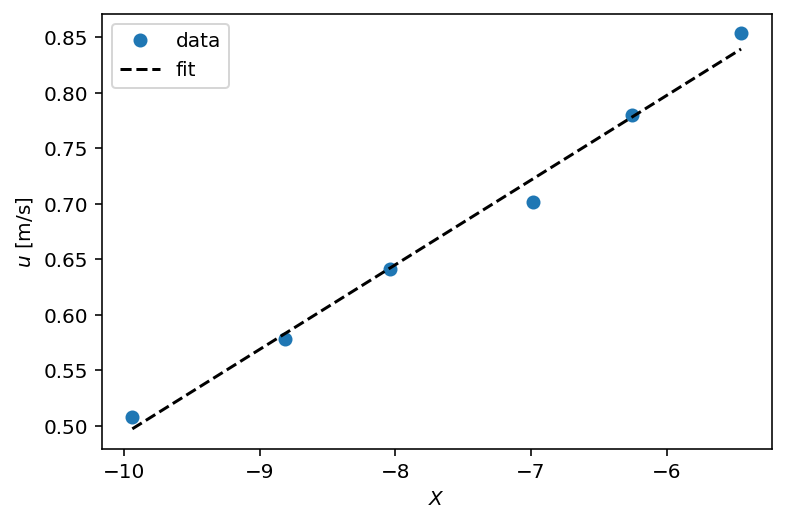

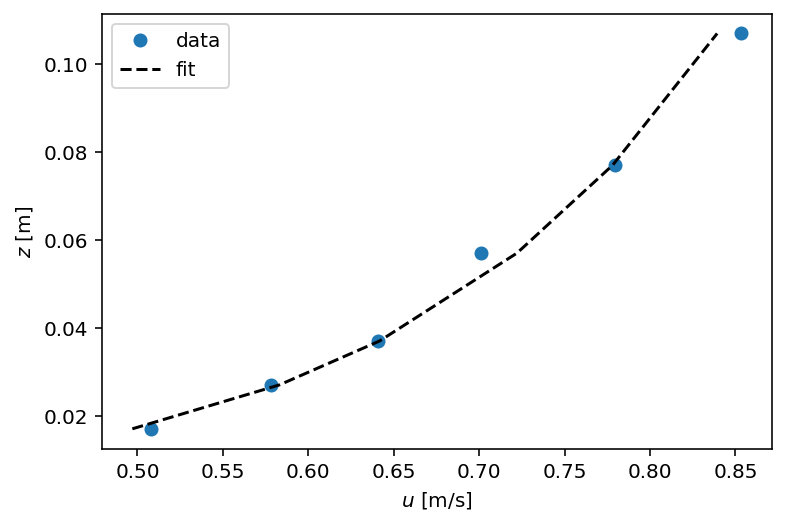

In [14]:
# create 1D arrays for ease
u=np.array(profile.uavg_m_s.copy())
z=np.array(profile.z_cm.copy()/100)

# depth avg vel
Uavg = np.trapz(u,z)/(z[-1]-z[0]) # depth average u for the profile
QUavg = Uavg*h*w
f_ds = 8*taub_ds/(rho*Uavg**2)
print('The depth average velocity, Uavg, is =',np.around(Uavg,decimals=2),'[m/s]')
print('Discharge based on Uavg and flow area =' ,np.around(QUavg,decimals=2),'[cms]')
print('')

# profile analysis

X = (1/kappa)*log(z) # create loged velocity variable
slope, intercept, r_value, p_value, std_err = stats.linregress(X,u)

ustar = slope
ks = exp(kappa*(B-(intercept/ustar)))
u_calc=ustar*((1/kappa)*log(z/ks)+B)
f = 8*ustar**2/Uavg**2

fig, ax = plt.subplots()
ax.plot(X,u, 'o',label='data')
ax.plot(X,slope*X+intercept, '--k', label='fit')
ax.set_xlabel('$X$')
ax.set_ylabel('$u$ [m/s]')
plt.legend()

fig, ax = plt.subplots()
ax.plot(u,z,'o',label='data')
ax.plot(u_calc,z, '--k',label='fit')
plt.legend()
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');

print('u* [m/s] =', np.around(ustar, decimals=4))
print('taub [N/m^2] =', np.around(rho*ustar**2, decimals=4))
print('ks [m] =', np.around(ks, decimals=5))
print('ks+ =', np.around(ustar*ks/nu, decimals=0))
print('R^2 =', np.around(r_value**2, decimals=4))

Try a different method of curve fitting that accounts for the zero velocity displacement height. Currently, data from these next two fits are not saved

u* [m/s] = 0.111
taub [N/m^2] = 12.3206
z0 [m] = 0.01873
ks [m] = 0.17685
ks+ = 14791.0


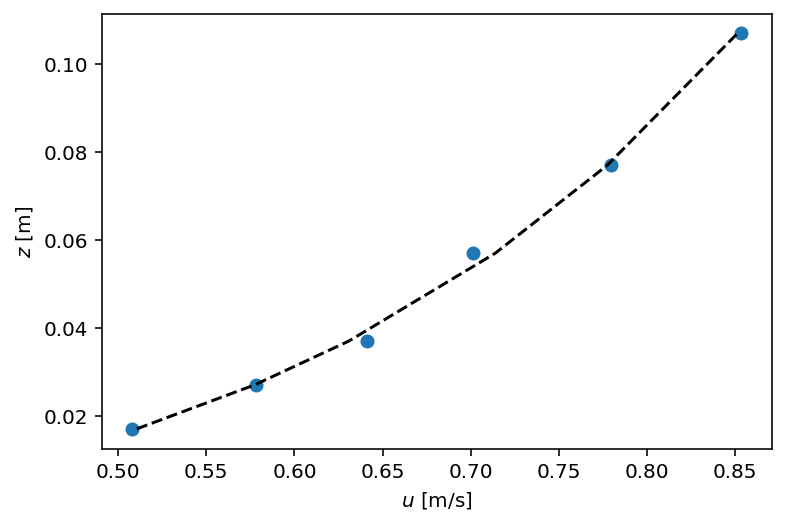

In [15]:
popt, pcov = curve_fit(rwlogfit2,z,u, bounds=(0, [1, 1, 1])) # popt is "ustar" from the fit
print('u* [m/s] =', np.around(popt[2], decimals=4))
print('taub [N/m^2] =', np.around(rho*popt[2]**2, decimals=4))
print('z0 [m] =', np.around(popt[0], decimals=5))
print('ks [m] =', np.around(popt[1], decimals=5))
print('ks+ =', np.around(popt[1]*popt[2]/nu, decimals=0))

fig, ax = plt.subplots()
ax.plot(u,z, 'o')
ax.plot(popt[2]*((1/kappa)*log((z+popt[0])/popt[1])+B),z, '--k')
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');

with $z_0$ tided to $k_s$, i.e., $z_0 = 0.25k_s$

u* [m/s] = 0.0752
taub [N/m^2] = 5.6596
ks [m] = 0.04655
ks+ = 2639.0


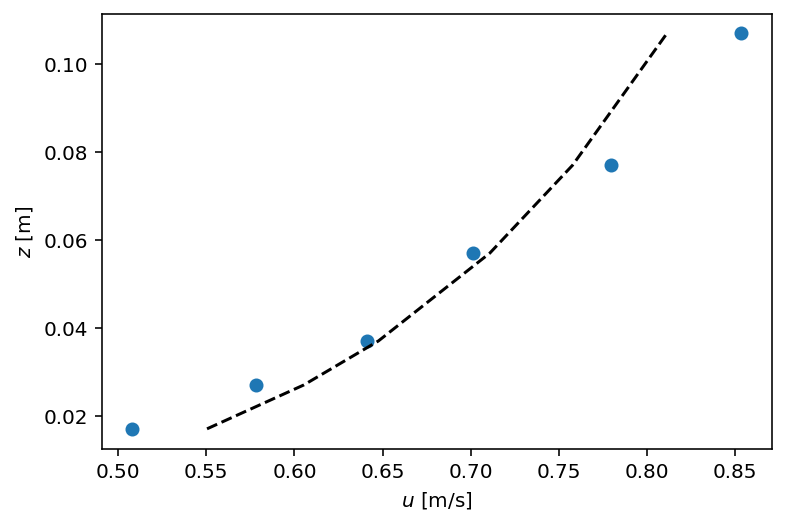

In [16]:
popt, pcov = curve_fit(rwlogfit,z,u, bounds=(0, [0.1, 0.1])) # popt is "ustar" from the fit
print('u* [m/s] =', np.around(popt[1], decimals=4))
print('taub [N/m^2] =', np.around(rho*popt[1]**2, decimals=4))
print('ks [m] =', np.around(popt[0], decimals=5))
print('ks+ =', np.around(popt[1]*popt[0]/nu, decimals=0))

fig, ax = plt.subplots()
ax.plot(u,z, 'o')
# ax.plot(popt[1]*((1/kappa)*log((z+0*popt[0])/popt[0])+B),z, '--k')
ax.plot(popt[1]*((1/kappa)*log((z+0.25*popt[0])/popt[0])+B),z, '--k')
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');

## Fit a line to the Reynolds stress to find a RS measure of the friction velocity 

Bed shear stress based on Reynolds stress [N/m^2]= 4.35
Friction velocity, u*, based on Reynolds stress [m/s]= 0.07


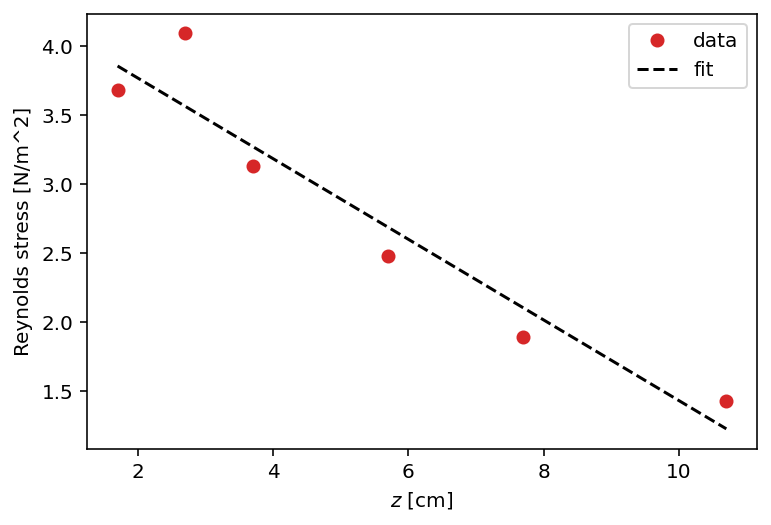

In [17]:
slope_uw, taub_uw, r_value, p_value, std_err = stats.linregress(profile.z_cm,-rho*profile.uw_bar)

ustar_uw = np.sqrt(taub_uw/rho)
print('Bed shear stress based on Reynolds stress [N/m^2]=',np.around(taub_uw,decimals=2))
print('Friction velocity, u*, based on Reynolds stress [m/s]=',np.around(ustar_uw,decimals=2))

fig, ax = plt.subplots()
ax.plot(profile.z_cm,-rho*profile.uw_bar, 'o', color='C03',label='data')
ax.plot(profile.z_cm,slope_uw*profile.z_cm+taub_uw, '--k', label='fit')
ax.set_xlabel('$z$ [cm]')
ax.set_ylabel('Reynolds stress [N/m^2]')
plt.legend();

## Export profile derived data as a csv

In [18]:
ustar_uw = np.sqrt(taub_uw/rho)
f_uw = 8*ustar_uw**2/Uavg**2

ptable = profile.loc[0:0][['Run','Q_cms','S','T_cm','x_m','h_cm']].copy()
ptable['Uavg_m_s']= Uavg
ptable['Q_Uavg_cms']=QUavg
ptable['ks_m']=ks
ptable['ustar_profile_m_s']=ustar
ptable['ustar_ds_m_s']= ustar_ds
ptable['ustar_uw_m_s'] = ustar_uw 
ptable['f_ds'] = f_ds
ptable['f_profile'] = f
ptable['f_uw'] = f_uw
ptable['taub_profile_Pa']= (f/8)*rho*Uavg**2
ptable['taub_ds_Pa']= taub_ds
ptable['taub_uw_Pa'] = (f_uw/8)*rho*Uavg**2

# ptable.to_csv(datadir+run+'_summary_profile.csv',index=False)

output_path=datadir+'/summary_profile_anal_indv.csv'
ptable.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path))

ptable

,Run,Q_cms,S,T_cm,x_m,h_cm,Uavg_m_s,Q_Uavg_cms,ks_m,ustar_profile_m_s,ustar_ds_m_s,ustar_uw_m_s,f_ds,f_profile,f_uw,taub_profile_Pa,taub_ds_Pa,taub_uw_Pa
0,Run1B,0.113,0.005,7.8,5.12,12.8,0.71394,0.109661,0.038353,0.076286,0.071934,0.065963,0.081215,0.091338,0.068291,5.817932,5.173099,4.349887
